In [1]:
import scipy.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [2]:
# Load the .mat file
cam1 = scipy.io.loadmat('cam1.mat')  # Change filename accordingly
cam2 = scipy.io.loadmat('cam2.mat')  # Change filename accordingly
cam3 = scipy.io.loadmat('cam3.mat')  # Change filename accordingly

cam_1 = cam1['vidFrames1_4']
cam_2 = cam2['vidFrames2_4']
cam_3 = cam3['vidFrames3_4']

In [60]:
def crop_dataset(dataset, x_min, x_max, y_min, y_max):
    """
    Crops the dataset to the given pixel range without rotating.

    Parameters:
    - dataset: numpy array (H, W, C, F) - Video dataset
    - x_min, x_max: int - Pixel range for cropping in the X direction
    - y_min, y_max: int - Pixel range for cropping in the Y direction

    Returns:
    - Processed dataset (cropped)
    """
    num_frames = dataset.shape[3]  # Number of frames

    # Initialize an array for the processed dataset
    processed_dataset = np.zeros((y_max - y_min, x_max - x_min, 3, num_frames), dtype=np.uint8)

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame
        cropped_frame = frame[y_min:y_max, x_min:x_max]  # Crop the frame
        processed_dataset[:, :, :, i] = cropped_frame  # Store the processed frame

    return processed_dataset

def rotate_dataset(dataset, rotation_angle):
    """
    Rotates the dataset clockwise by the given angle without cropping.

    Parameters:
    - dataset: numpy array (H, W, C, F) - Video dataset
    - rotation_angle: float - Rotation angle in degrees (clockwise)

    Returns:
    - Processed dataset (rotated without cropping)
    """
    num_frames = dataset.shape[3]  # Number of frames
    h, w = dataset.shape[:2]  # Original height and width

    # Initialize an array for the rotated dataset
    rotated_dataset = np.zeros_like(dataset)

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame

        # Rotate the frame
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, -rotation_angle, 1)  # Negative for clockwise rotation
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (w, h))

        # Store the processed frame
        rotated_dataset[:, :, :, i] = rotated_frame

    return rotated_dataset

def create_video_from_dataset(dataset, output_video, fps=30):
    """
    Creates a video from a processed dataset (cropped and rotated frames).

    Parameters:
    - dataset: numpy array (H, W, C, F) - Processed video dataset
    - output_video: str - Path to save the output video file.
    - fps: int - Frames per second for the video.

    Returns:
    - None (saves the video to the specified path)
    """
    num_frames = dataset.shape[3]  # Number of frames
    height, width = dataset.shape[:2]  # Get frame dimensions

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format
        out.write(frame_bgr)

    out.release()
    print(f"Video saved: {output_video}")

In [4]:
#Run this to load a raw dataset without cropping to compare with

data = scipy.io.loadmat('cam3.mat')

# Print keys to see available variables
print(data.keys())
keys = list(data.keys())
vid_frames = data[keys[-1]]
print(vid_frames.shape)

dict_keys(['__header__', '__version__', '__globals__', 'vidFrames3_4'])
(480, 640, 3, 394)


In [5]:
#Cropping the videos
dataset1 = crop_dataset(cam_1, 300, 500, 220, 450)

dataset2 = crop_dataset(cam_2, 200, 480, 60, 400)

cropped_dataset3 = crop_dataset(cam_3, 300, 500, 130, 300)
dataset3 = rotate_dataset(cropped_dataset3, 90)

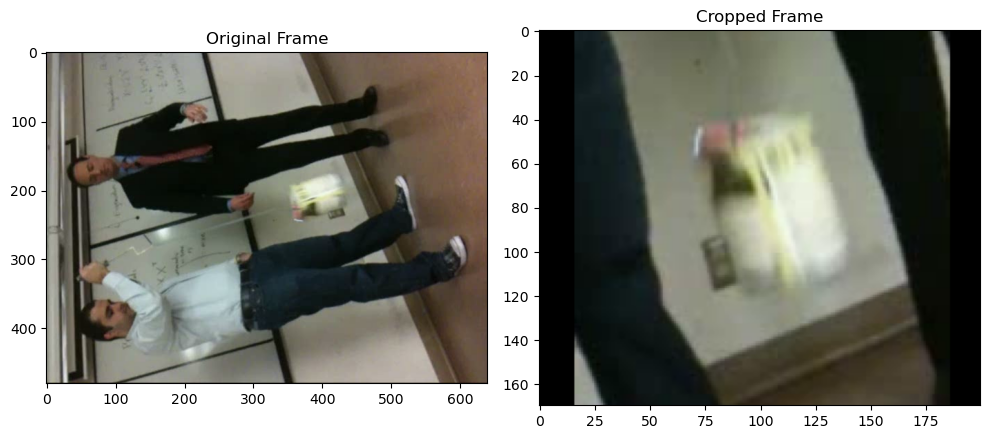

In [7]:

# Extract the 15th frame
first_frame = vid_frames[:, :, :, 1]  
cropped_frame = dataset3[:, :, :, 1]  

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the original frame
axes[0].imshow(first_frame)
axes[0].set_title("Original Frame")
axes[0].axis("on")

# Display the cropped frame
axes[1].imshow(cropped_frame)
axes[1].set_title("Cropped Frame")
axes[1].axis("on")

# Show the plots
plt.tight_layout()
plt.show()


In [8]:
create_video_from_dataset(dataset1, "cam1.mp4", fps=30)
create_video_from_dataset(dataset2, "cam2.mp4", fps=30)
create_video_from_dataset(dataset3, "cam3.mp4", fps=30)

Video saved: cam1.mp4
Video saved: cam2.mp4
Video saved: cam3.mp4


In [11]:
#compress datasets and save them so that all steps dont need to be repeated when reopening the file
save_dataset(dataset1, "camera1_cropped.npz")
save_dataset(dataset2, "camera2_cropped.npz")
save_dataset(dataset3, "camera3_cropped.npz")

Final dataset saved to camera1_cropped.npz
Final dataset saved to camera2_cropped.npz
Final dataset saved to camera3_cropped.npz


Number of frames: 392


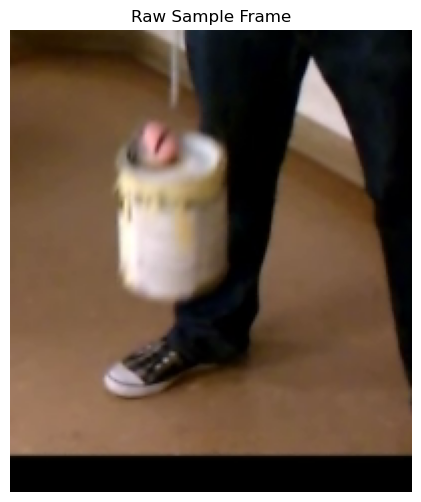

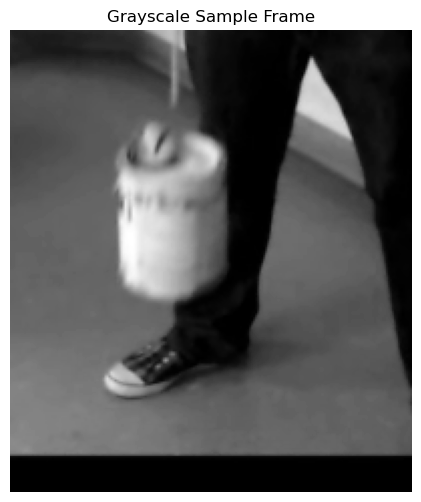

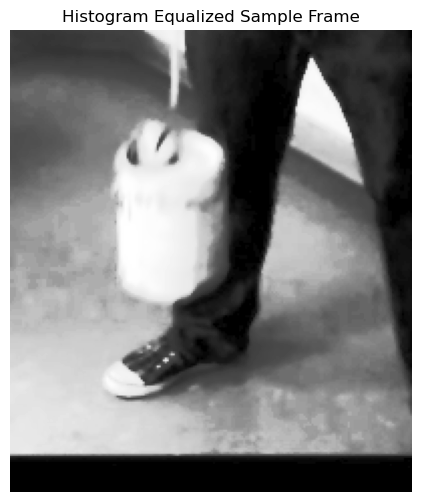

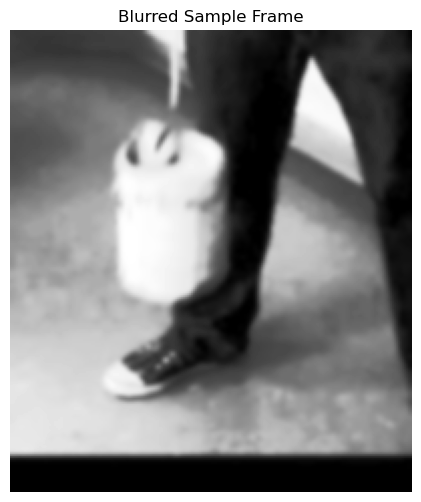

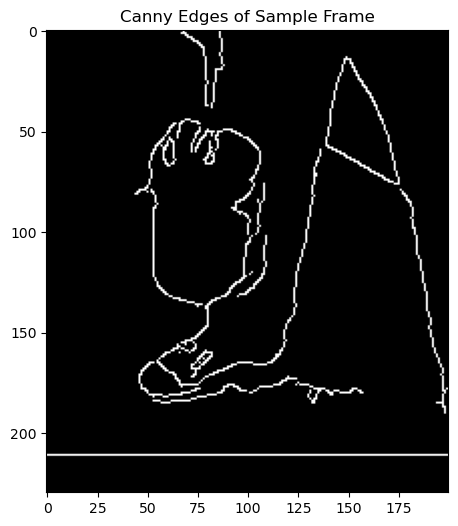

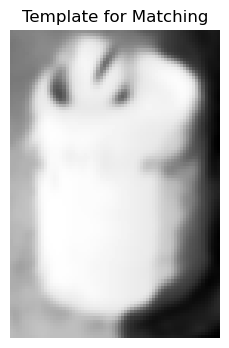

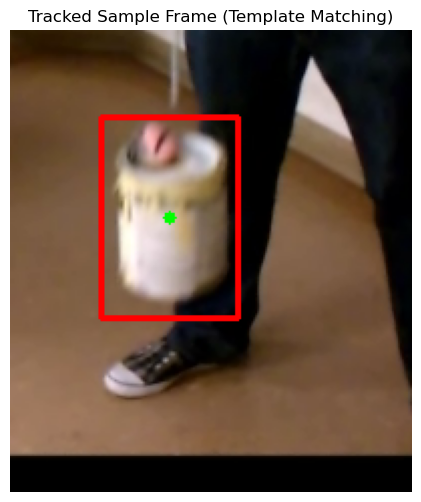

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.
Overlayed video saved as 'tracked_video.mp4'.


In [54]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ============================
# LOAD DATASET
# ============================
data = np.load("camera1_cropped.npz")
video_frames = data["data"]  # Expected shape: (H, W, 3, F)
num_frames = video_frames.shape[3]
print("Number of frames:", num_frames)

# ============================
# STEP 1: Display a Raw Sample Frame
# ============================
sample_index = 100  # Change this index as needed
raw_frame = video_frames[:, :, :, sample_index]
plt.figure(figsize=(6,6))
plt.imshow(raw_frame)
plt.title("Raw Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 2: Convert to Grayscale
# ============================
gray_sample = cv2.cvtColor(raw_frame, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(gray_sample, cmap="gray")
plt.title("Grayscale Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 3: Enhance Contrast via Histogram Equalization
# ============================
equalized_sample = cv2.equalizeHist(gray_sample)
plt.figure(figsize=(6,6))
plt.imshow(equalized_sample, cmap="gray")
plt.title("Histogram Equalized Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 4: Apply Gaussian Blur to Reduce Noise
# ============================
blurred_sample = cv2.GaussianBlur(equalized_sample, (5,5), 0)
plt.figure(figsize=(6,6))
plt.imshow(blurred_sample, cmap="gray")
plt.title("Blurred Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 5: (Optional) Apply Canny Edge Detection to Inspect Edges
# ============================
edges_sample = cv2.Canny(blurred_sample, 50, 150)
plt.figure(figsize=(6,6))
plt.imshow(edges_sample, cmap="gray")
plt.title("Canny Edges of Sample Frame")
plt.axis("on")
plt.show()

# ============================
# STEP 6: Define a Template for the Can
#
# Manually select a region from the processed sample where the can appears.
# Adjust the coordinates (template_x, template_y, template_w, template_h) as needed.
# ============================
template_x, template_y, template_w, template_h = 45, 43, 68, 100  # Example values; adjust as needed!
template = blurred_sample[template_y:template_y+template_h, template_x:template_x+template_w]
plt.figure(figsize=(4,4))
plt.imshow(template, cmap="gray")
plt.title("Template for Matching")
plt.axis("off")
plt.show()

# ============================
# STEP 7: Track the Can Using Template Matching Over All Frames
# ============================
tracked_positions = np.zeros((num_frames, 2))  # To store the center (x, y) of the match
# Create a copy of the original dataset for overlaying tracking results
overlay_frames = np.copy(video_frames).astype(np.uint8)
match_threshold = 0.65  # Set your correlation threshold here

for i in range(num_frames):
    frame = video_frames[:, :, :, i]
    # Process the frame: grayscale, equalize, and blur
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (5,5), 0)
    
    # Apply template matching
    result = cv2.matchTemplate(blurred, template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    
    # Check the match quality against the threshold
    if max_val < match_threshold:
        # If below threshold, use the previous frame's position if available
        if i > 0:
            center = (int(tracked_positions[i-1, 0]), int(tracked_positions[i-1, 1]))
            # Recalculate top_left based on previous center for drawing
            top_left = (center[0] - template_w // 2, center[1] - template_h // 2)
        else:
            center = (0, 0)
            top_left = (0, 0)
    else:
        top_left = max_loc  # Best match top-left corner
        center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)
    
    tracked_positions[i] = center
    
    # Draw the rectangle and center on the frame
    frame_to_draw = overlay_frames[:, :, :, i].copy()
    bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
    cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangle
    cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)               # Green dot
    overlay_frames[:, :, :, i] = frame_to_draw

# ============================
# STEP 8: Display a Sample Tracked Frame for Inspection
# ============================
tracked_sample = overlay_frames[:, :, :, sample_index]
plt.figure(figsize=(6,6))
plt.imshow(tracked_sample)
plt.title("Tracked Sample Frame (Template Matching)")
plt.axis("off")
plt.show()

# ============================
# STEP 9: Save the Overlayed Dataset and Tracked Positions
# ============================
np.savez_compressed("camera1_tracked.npz", overlayed_frames=overlay_frames, positions=tracked_positions)
print("Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.")

# ============================
# STEP 10: Save the Overlayed Dataset as a Video
# ============================
def create_video_from_dataset(dataset, output_video, fps=30):
    """
    Creates a video file from a dataset of frames.
    
    Parameters:
    - dataset: numpy array (H, W, C, F) - Processed video frames
    - output_video: str - Output video filename (e.g., 'tracked_video.mp4')
    - fps: int - Frames per second for the video
    
    Returns:
    - None (saves the video file)
    """
    num_frames = dataset.shape[3]
    height, width = dataset.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))
    for i in range(num_frames):
        frame = dataset[:, :, :, i]
        # Convert from RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()

create_video_from_dataset(overlay_frames, "tracked_video.mp4", fps=30)
print("Overlayed video saved as 'tracked_video.mp4'.")


Number of frames: 392


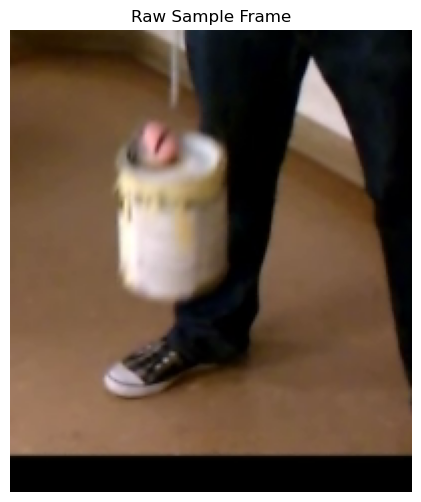

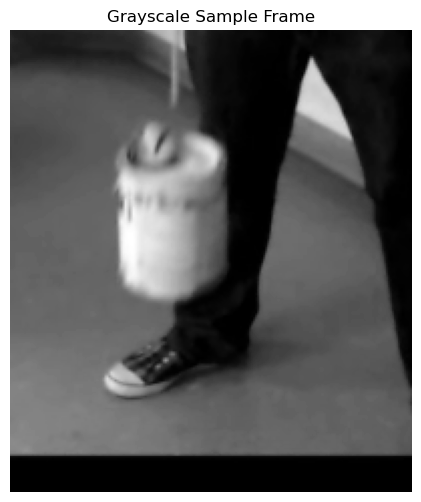

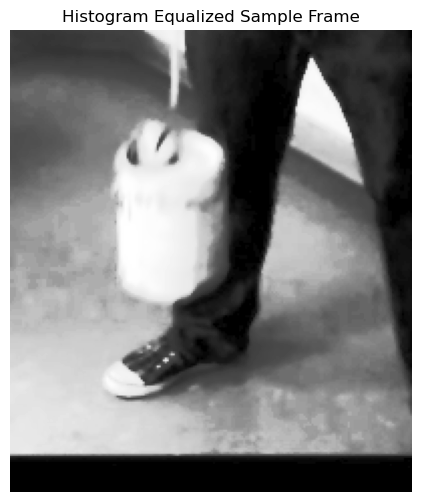

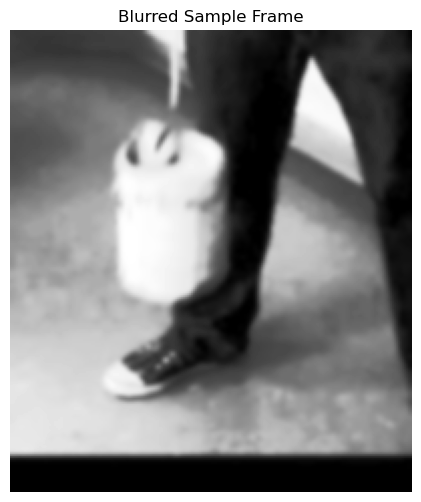

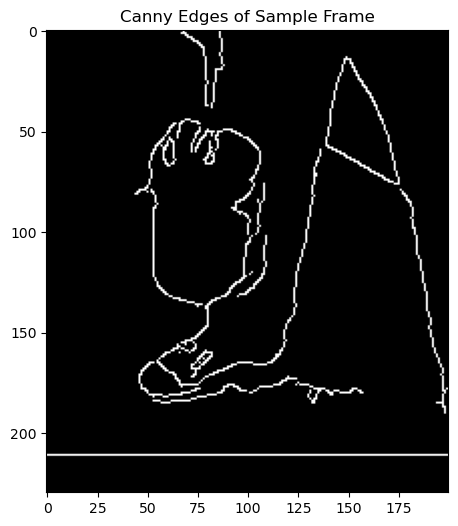

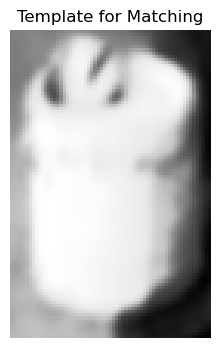

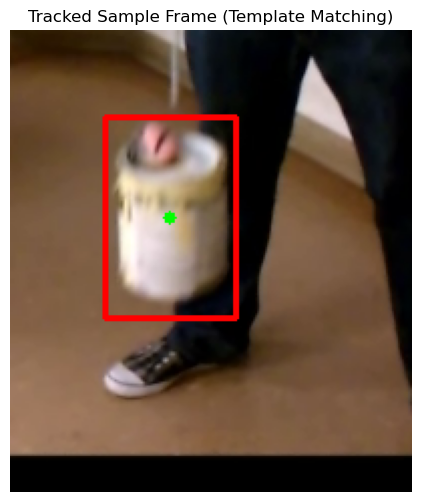

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.
Overlayed video saved as 'tracked_video.mp4'.


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [61]:
##Best Method

# ============================
# LOAD DATASET
# ============================
data = np.load("camera1_cropped.npz")
video_frames = data["data"]  # Expected shape: (H, W, 3, F)
num_frames = video_frames.shape[3]
print("Number of frames:", num_frames)

# ============================
# STEP 1: Display a Raw Sample Frame
# ============================
sample_index = 100  # Change this index as needed
raw_frame = video_frames[:, :, :, sample_index]
plt.figure(figsize=(6,6))
plt.imshow(raw_frame)
plt.title("Raw Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 2: Convert to Grayscale
# ============================
gray_sample = cv2.cvtColor(raw_frame, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(gray_sample, cmap="gray")
plt.title("Grayscale Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 3: Enhance Contrast via Histogram Equalization
# ============================
equalized_sample = cv2.equalizeHist(gray_sample)
plt.figure(figsize=(6,6))
plt.imshow(equalized_sample, cmap="gray")
plt.title("Histogram Equalized Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 4: Apply Gaussian Blur to Reduce Noise
# ============================
blurred_sample = cv2.GaussianBlur(equalized_sample, (5,5), 0)
plt.figure(figsize=(6,6))
plt.imshow(blurred_sample, cmap="gray")
plt.title("Blurred Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 5: (Optional) Apply Canny Edge Detection to Inspect Edges
# ============================
edges_sample = cv2.Canny(blurred_sample, 50, 150)
plt.figure(figsize=(6,6))
plt.imshow(edges_sample, cmap="gray")
plt.title("Canny Edges of Sample Frame")
plt.axis("on")
plt.show()

# ============================
# STEP 6: Define a Template for the Can
#
# Manually select a region from the processed sample where the can appears.
# Adjust the coordinates (template_x, template_y, template_w, template_h) as needed.
# ============================
template_x, template_y, template_w, template_h = 47, 43, 65, 100  # Example values; adjust as needed!
template = blurred_sample[template_y:template_y+template_h, template_x:template_x+template_w]
plt.figure(figsize=(4,4))
plt.imshow(template, cmap="gray")
plt.title("Template for Matching")
plt.axis("off")
plt.show()

# ============================
# STEP 7: Track the Can Using Template Matching Over All Frames
# ============================
tracked_positions = np.zeros((num_frames, 2))  # To store the center (x, y) of the match
# Create a copy of the original dataset for overlaying tracking results
overlay_frames = np.copy(video_frames).astype(np.uint8)
match_threshold = 0.65    # Minimum acceptable match score
max_move_distance = 20    # Maximum allowed movement (in pixels) between consecutive frames

for i in range(num_frames):
    frame = video_frames[:, :, :, i]
    # Process the frame: grayscale, equalize, and blur
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (5,5), 0)
    
    # Apply template matching
    result = cv2.matchTemplate(blurred, template, cv2.TM_CCOEFF_NORMED)
    
    # For the first frame, just take the best match
    if i == 0:
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)
    else:
        # Sort candidate locations by score (in descending order)
        sorted_indices = np.argsort(-result.ravel())
        best_candidate_found = False
        prev_center = tracked_positions[i-1]
        for idx in sorted_indices:
            r, c = np.unravel_index(idx, result.shape)
            candidate_score = result[r, c]
            if candidate_score < match_threshold:
                # Since sorted in descending order, no later candidate will be above threshold
                break
            candidate_center = (c + template_w // 2, r + template_h // 2)
            distance = np.linalg.norm(np.array(candidate_center) - np.array(prev_center))
            if distance <= max_move_distance:
                best_candidate_found = True
                top_left = (c, r)
                center = candidate_center
                break
        if not best_candidate_found:
            # Fallback: use previous center
            center = (int(prev_center[0]), int(prev_center[1]))
            top_left = (center[0] - template_w // 2, center[1] - template_h // 2)
    
    tracked_positions[i] = center
    
    # Draw the rectangle and center on the frame
    frame_to_draw = overlay_frames[:, :, :, i].copy()
    bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
    cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangle
    cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)               # Green dot
    overlay_frames[:, :, :, i] = frame_to_draw

# ============================
# STEP 8: Display a Sample Tracked Frame for Inspection
# ============================
tracked_sample = overlay_frames[:, :, :, sample_index]
plt.figure(figsize=(6,6))
plt.imshow(tracked_sample)
plt.title("Tracked Sample Frame (Template Matching)")
plt.axis("off")
plt.show()

# ============================
# STEP 9: Save the Overlayed Dataset and Tracked Positions
# ============================
np.savez_compressed("camera1_tracked.npz", overlayed_frames=overlay_frames, positions=tracked_positions)
print("Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.")

# ============================
# STEP 10: Save the Overlayed Dataset as a Video
# ============================
def create_video_from_dataset(dataset, output_video, fps=30):
    """
    Creates a video file from a dataset of frames.
    
    Parameters:
    - dataset: numpy array (H, W, C, F) - Processed video frames
    - output_video: str - Output video filename (e.g., 'tracked_video.mp4')
    - fps: int - Frames per second for the video
    
    Returns:
    - None (saves the video file)
    """
    num_frames = dataset.shape[3]
    height, width = dataset.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))
    for i in range(num_frames):
        frame = dataset[:, :, :, i]
        # Convert from RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()

create_video_from_dataset(overlay_frames, "tracked_video.mp4", fps=30)
print("Overlayed video saved as 'tracked_video.mp4'.")


Number of frames: 392


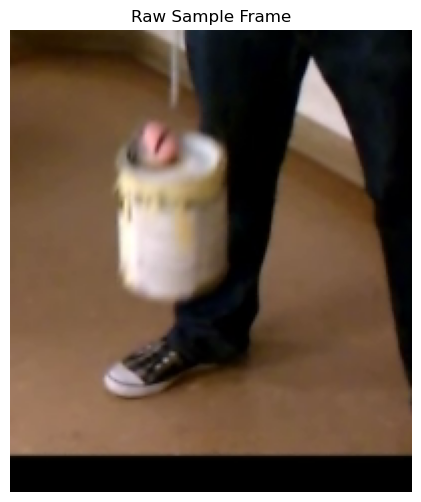

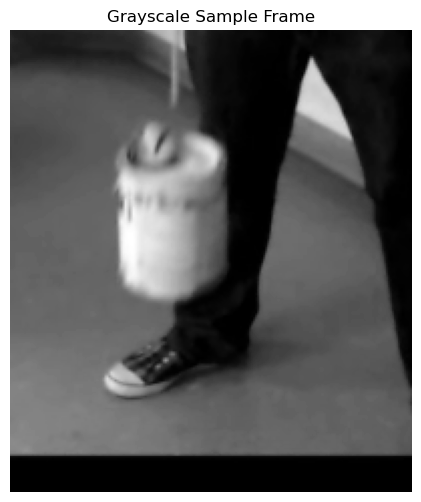

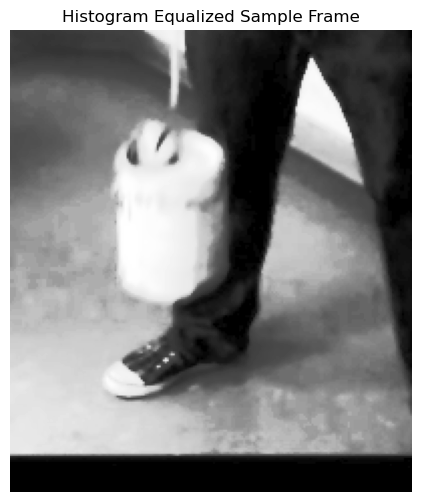

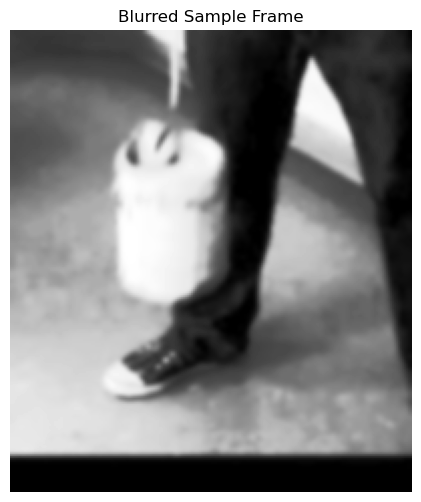

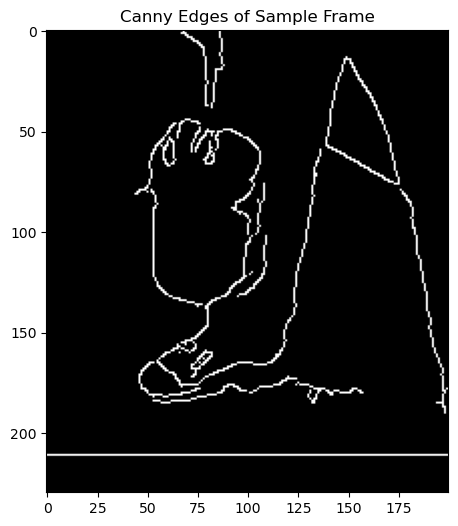

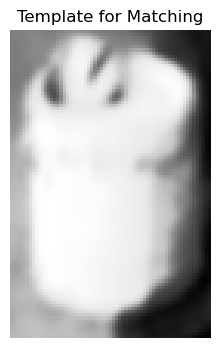

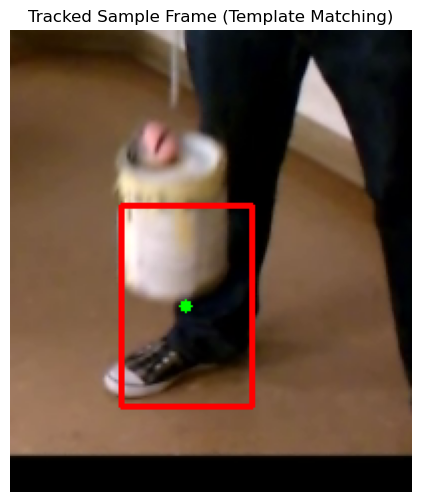

Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.
Overlayed video saved as 'tracked_video.mp4'.


In [50]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ============================
# LOAD DATASET
# ============================
data = np.load("camera1_cropped.npz")
video_frames = data["data"]  # Expected shape: (H, W, 3, F)
num_frames = video_frames.shape[3]
print("Number of frames:", num_frames)

# ============================
# STEP 1: Display a Raw Sample Frame
# ============================
sample_index = 100  # Change this index as needed
raw_frame = video_frames[:, :, :, sample_index]
plt.figure(figsize=(6,6))
plt.imshow(raw_frame)
plt.title("Raw Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 2: Convert to Grayscale
# ============================
gray_sample = cv2.cvtColor(raw_frame, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(gray_sample, cmap="gray")
plt.title("Grayscale Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 3: Enhance Contrast via Histogram Equalization
# ============================
equalized_sample = cv2.equalizeHist(gray_sample)
plt.figure(figsize=(6,6))
plt.imshow(equalized_sample, cmap="gray")
plt.title("Histogram Equalized Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 4: Apply Gaussian Blur to Reduce Noise
# ============================
blurred_sample = cv2.GaussianBlur(equalized_sample, (5,5), 0)
plt.figure(figsize=(6,6))
plt.imshow(blurred_sample, cmap="gray")
plt.title("Blurred Sample Frame")
plt.axis("off")
plt.show()

# ============================
# STEP 5: (Optional) Apply Canny Edge Detection to Inspect Edges
# ============================
edges_sample = cv2.Canny(blurred_sample, 50, 150)
plt.figure(figsize=(6,6))
plt.imshow(edges_sample, cmap="gray")
plt.title("Canny Edges of Sample Frame")
plt.axis("on")
plt.show()

# ============================
# STEP 6: Define a Template for the Can
#
# Manually select a region from the processed sample where the can appears.
# Adjust the coordinates (template_x, template_y, template_w, template_h) as needed.
# ============================
template_x, template_y, template_w, template_h = 47, 43, 65, 100  # Example values; adjust as needed!
template = blurred_sample[template_y:template_y+template_h, template_x:template_x+template_w]
plt.figure(figsize=(4,4))
plt.imshow(template, cmap="gray")
plt.title("Template for Matching")
plt.axis("off")
plt.show()

# ============================
# STEP 7: Track the Can Using Template Matching Over All Frames
# ============================
tracked_positions = np.zeros((num_frames, 2))  # To store the center (x, y) of the match
# Create a copy of the original dataset for overlaying tracking results
overlay_frames = np.copy(video_frames).astype(np.uint8)
match_threshold = 0.65    # Minimum acceptable match score
max_move_distance = 20    # Maximum allowed movement (in pixels) between consecutive frames

# Parameters for dynamic template update:
update_threshold = 0.75  # Only update if the match is very strong
alpha = 0.3              # Update rate (0.1 means 10% update from the candidate patch)

for i in range(num_frames):
    frame = video_frames[:, :, :, i]
    # Process the frame: grayscale, equalize, and blur
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (3,3), 0)
    
    # Apply template matching
    result = cv2.matchTemplate(blurred, template, cv2.TM_CCOEFF_NORMED)
    
    if i == 0:
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)
    else:
        # Sort candidate locations by score (in descending order)
        sorted_indices = np.argsort(-result.ravel())
        best_candidate_found = False
        prev_center = tracked_positions[i-1]
        for idx in sorted_indices:
            r, c = np.unravel_index(idx, result.shape)
            candidate_score = result[r, c]
            if candidate_score < match_threshold:
                break  # No candidate above threshold remains
            candidate_center = (c + template_w // 2, r + template_h // 2)
            distance = np.linalg.norm(np.array(candidate_center) - np.array(prev_center))
            if distance <= max_move_distance:
                best_candidate_found = True
                top_left = (c, r)
                center = candidate_center
                break
        if not best_candidate_found:
            # Fallback: use previous center
            center = (int(prev_center[0]), int(prev_center[1]))
            top_left = (center[0] - template_w // 2, center[1] - template_h // 2)
    
    tracked_positions[i] = center
    
    # Dynamic template update: if the match is very strong, update the template
    if i > 0 and result is not None:
        # Recompute max_val for clarity (could reuse if stored)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        if max_val > update_threshold:
            # Extract candidate patch from the current processed frame
            candidate_patch = blurred[top_left[1]:top_left[1]+template_h, top_left[0]:top_left[0]+template_w]
            # Check shape to ensure it matches the template dimensions
            if candidate_patch.shape == template.shape:
                # Blend the current template with the candidate patch
                template = cv2.addWeighted(template, 1 - alpha, candidate_patch, alpha, 0)
    
    # Draw the rectangle and center on the frame
    frame_to_draw = overlay_frames[:, :, :, i].copy()
    bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
    cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangle
    cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)               # Green dot
    overlay_frames[:, :, :, i] = frame_to_draw

# ============================
# STEP 8: Display a Sample Tracked Frame for Inspection
# ============================
tracked_sample = overlay_frames[:, :, :, sample_index]
plt.figure(figsize=(6,6))
plt.imshow(tracked_sample)
plt.title("Tracked Sample Frame (Template Matching)")
plt.axis("off")
plt.show()

# ============================
# STEP 9: Save the Overlayed Dataset and Tracked Positions
# ============================
np.savez_compressed("camera1_tracked.npz", overlayed_frames=overlay_frames, positions=tracked_positions)
print("Tracking complete. Overlayed frames and tracked positions saved to 'camera1_tracked.npz'.")

# ============================
# STEP 10: Save the Overlayed Dataset as a Video
# ============================
create_video_from_dataset(overlay_frames, "tracked_video.mp4", fps=30)
print("Overlayed video saved as 'tracked_video.mp4'.")
